# **2. Transfer Learning for Computer Vision Tutorial**

Transfer Learning 을 활용해 이미지 분류를 위한 CNN 학습


실제로 전체 CNN을 처음부터 학습하는 경우는 드뭄

그 이유는 그렇게 하기에 충분히 큰 규모의 데이터셋을 확보하기 어렵기 때문에

일반적으로는 ImageNet(120만장, 1000개 클래스) 로 먼저 ConvNet을 사전 학습 시키고

그 모델을 사용자가 원하는 작업게 맞게 초기화 하거나 fixed feature extractor로 활용함



전이 학습의 대표적인 두 가지 시나리오

1. ConvNet 파인튜닝

  - 무작위 초기화 대신 ImageNet 1000 클래스에 대해 사전학습된 네트워크의 가중치로 초기화

  - 이후의 학습과정은 일반적인 방식과 동일하게 전체 네트워크의 가중치를 계속 업데이트

2. ConvNet을 고정된 특징 추출기로 사용

  - 네트워크의 모든 가중치는 동결 (freeze) 하고

  - 마지막 Fully Connected Layer 를 새로 정의하고 무작위로 초기화 함

  - 이때 학습은 오직 마지막 분류기 레이어만 진행됩니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

# Load Data

개미와 벌을 분류해보자

훈련용 이미지는 클래스당 약 120장, validation 이미지는 클래스당 75장

이건 처음부터 학습하기에는 너무 작은 데이터셋임

우리는 전이학습할거 괜찮다

In [ ]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224), # 224 x 224 크기로 랜덤 크롭
        transforms.RandomHorizontalFlip(), # 좌우 반전
        transforms.ToTensor(), # PIL -> Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 평균값과 표준편차로 정규화
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256), # 짧은 축 기준 256 으로 리사이즈
        transforms.CenterCrop(224), # 중심 기준 224 x 224 크롭
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/학부연구생/Pytorch - Image and Video/hymenoptera_data'
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), # 폴더명을 클래스명으로 매핑시킴
                                           data_transforms[x])
for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle = True,
                                              num_workers=4)
for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']} # 이미지 개수
class_names = image_datasets['train'].classes # 클래스 이름 리스트

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# VIsualize a few images

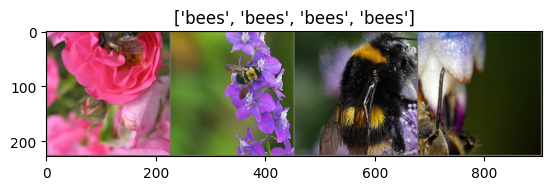

In [ ]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0)) # (C, H, W) -> (H, W, C)

  # ImageNet 정규화 역변화
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean # 원래 이미지로 복원
  inp = np.clip(inp, 0 ,1) # [0, 1] 범위로 클리핑

  # 시각화
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train'])) # 배치 하나를 꺼냄

out = torchvision.utils.make_grid(inputs) # 여러 이미지를 1장의 큰 이미지 형태로 합침

imshow(out, title =[class_names[x] for x in classes]) # 시각화

# Training the model

In [ ]:
# criterion : 손실함수, scheduler : 학습률 스케줄러 (epoch마다 lr 조정)
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time() # 학습 소요 시간을 측정하기 위해 시작 시간 기록

  # 가장 성능이 좋은 모델 파라미터를 저장할 임시 파일 경로 설정
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    # 초기 상태의 모델 가중치 저장
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      # train / validation 단계 분리
      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()
        else:
          model.eval()

        # 변수 초기화
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad() # 이전 gradient 초기화

          with torch.set_grad_enabled(phase == 'train'): # train 에서만 gradient 계산
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train': # train 의 경우에만 역전파와 가중치 업데이트
              loss.backward()
              optimizer.step()

          running_loss += loss.item() * inputs.size(0) # 배치 단위 누적
          running_corrects += torch.sum(preds == labels.data) # 맞춘 계수
        if phase == 'train': # train의 경우 스케줄러 업데이트
          scheduler.step()

        # 에폭 단위 loss와 acc 출력
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # 현재 에폭의 validation 정확도가 최고일 경우 가중치 저장
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - since # 학습 시간 측정 및 종료
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc:  {best_acc:4f}')

    # 가장 성능이 좋았던 모델 가중치를 불러와서 반환
    model.load_state_dict(torch.load(best_model_params_path, weights_only = True))

  return model

# Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images = 6):
  was_training = model.training # 함수 실행 전 모델이 train 모드였는지 기록
  model.eval() # 평가모드로 바꿈
  images_so_far = 0 # 지금까지 출력한 이미지 수를 추적할 변수
  fig = plt.figure()

  with torch.no_grad(): # validation set을 반복할거니까 gradient 계산 비활성화
    for i, (inputs, labels) in enumerate(dataloaders['val']): # 한 배치씩 꺼내옴
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1) # 각 이미지에 대한 예측 클래스 인덱스 추출

      for j in range(inputs.size()[0]): # 현재 배치 안의 모든 이미지에 대해 loop
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode = was_training) # 원래 train 이였음 train mode 로
          return

    model.train(model = was_training)

# Finetuning the ConvNet

마지막 레이어만 교체한뒤 파인튜닝 설정하기

In [ ]:
model_ft = models.resnet18(weights = 'IMAGENET1K_V1') # 사전 학습된 resnet18 불러옴

# 기존 fully connected 레이어 정보 얻기
# fc.in_features : 마지막 fully connected layer로 들어가는 입력 차원 수
num_ftrs = model_ft.fc.in_features

# 기존 fc 레이어를 2클래스 분류용으로 교체
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # 손실 함수 정의

# 옵티마이저에 모델 전체 파라미터를 전달
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# StepLR : 에폭이 step_size 만큼 지날 때마다 학습률을 gamma 배 감소 시킴
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2571 Acc: 0.8770
val Loss: 0.1706 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.2250 Acc: 0.9262
val Loss: 0.1792 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3744 Acc: 0.8197
val Loss: 0.1652 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.2860 Acc: 0.8525
val Loss: 0.1782 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3310 Acc: 0.8566
val Loss: 0.1660 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.2966 Acc: 0.8648
val Loss: 0.1982 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.2627 Acc: 0.8934
val Loss: 0.1604 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2330 Acc: 0.9016
val Loss: 0.1701 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2170 Acc: 0.9139
val Loss: 0.1903 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3012 Acc: 0.8689
val Loss: 0.1805 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2451 Acc: 0.9139
val Loss: 0.1722 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3630 Acc: 0.8443
val Loss: 0.1723 Acc: 0.9281

Ep

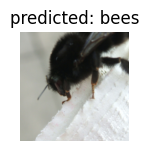

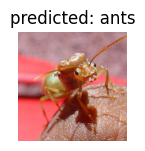

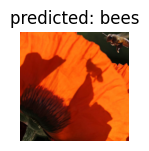

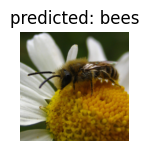

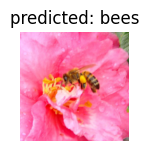

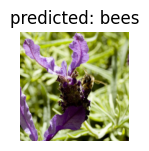

In [ ]:
visualize_model(model_ft)

# Convnet as fixed feature extractor

위의 파인튜닝과는 다르게

기존의 모든 층을 동결(freeze) 시키고 마지막 레이어만 학습시킨다

In [ ]:
model_conv = torchvision.models.resnet18(weights = 'IMAGENET1K_V1') # resnet18 불러오기

# 모든 파라미터의 requires_grad를 false로 설정해 동결시킴
# 역전파 시에 gradient 계산이 생략되니까 학습 대상이 안됨
# 결과적으로 모델은 fixed feature extractor 처럼 동작할거임
for param in model_conv.parameters():
  param.requires_grad = False

# 마지막 분류기 출력을 2로 바꾸고
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

creiterion = nn.CrossEntropyLoss()

# 옵티마이저에 fully connected 파라미터만 전달
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and evaluate

In [ ]:
model_conv = train_model(model_conv, creiterion, optimizer_conv, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6267 Acc: 0.6148
val Loss: 0.3283 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.4241 Acc: 0.8115
val Loss: 0.1775 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4007 Acc: 0.8115
val Loss: 0.1967 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5215 Acc: 0.7746
val Loss: 0.3213 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.4584 Acc: 0.8033
val Loss: 0.1841 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4720 Acc: 0.8115
val Loss: 0.1582 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.4662 Acc: 0.7951
val Loss: 0.2032 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3704 Acc: 0.8279
val Loss: 0.1689 Acc: 0.9673

Epoch 8/24
----------
train Loss: 0.4895 Acc: 0.7828
val Loss: 0.1695 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.4176 Acc: 0.8074
val Loss: 0.1705 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3544 Acc: 0.8443
val Loss: 0.1822 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3370 Acc: 0.8484
val Loss: 0.1783 Acc: 0.9608

Ep

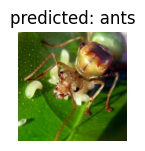

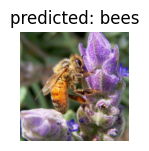

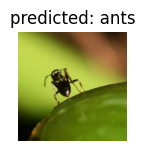

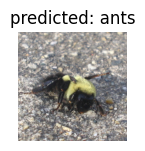

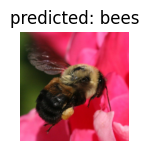

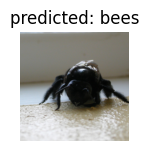

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Inference on custom images

In [ ]:
def visualize_model_predictions(model, img_path):
  was_training = model.training
  model.eval()

  # 이미지 불러오기 및 전처리
  img = Image.open(img_path) # PIL 이미지 로딩
  img = data_transforms['val'](img) # validation 용 전처리
  img = img.unsqueeze(0) # (C, H, W) -> (1, C, H, W) 로 배치 차원 추가
  img = img.to(device)

  with torch.no_grad(): # 추론이니까 gradient 추적 필요없음
    outputs = model(img) # 각 클래스에 대한 로짓 출력
    _, preds = torch.max(outputs, 1) # 가장 확률 높은 클래스 인덱스

    ax = plt.subplot(2, 2, 1)
    ax.axis('off')
    ax.set_title(f'Predicted: {class_names[preds[0]]}')
    imshow(img.cpu().data[0])

    model.train(mode=was_training)

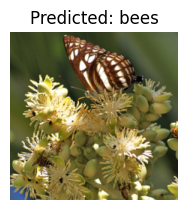

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path = '/content/drive/MyDrive/학부연구생/Pytorch - Image and Video/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()